##########**TRABAJO FINAL- VISÓN 3D**#################

Importamos las librerías necesarias:

In [3]:
import numpy as np
import cv2
import glob #la librería glob sirve para encontrar los nombres de los archivos 
import matplotlib.pyplot as plt

Cargar las imagenes del tablero para la calibracion de la cámara y su previa detección con opencv de las esquinas y la lectura de las imagenes

In [5]:

# Cargar las imágenes corregidas del tablero de ajedrez que hemos hecho previamente
images = glob.glob('./undistorted_*.jpeg')

# Definimos los parámetros del tablero para la detección
square_size = 25  # Tamaño de cada cuadro
pattern_size = (7, 7)  # Número de cuadros del patrón de ajedrez
contador = 0

# Crear las coordenadas 3D reales de los puntos del tablero
object_points = np.zeros((np.prod(pattern_size), 3), np.float32) 

# Suponemos que el patrón es plano sobre z=0, y que cada cuadro tiene tamaño "square_size"
# Se genera una lista con las posiciones (x, y, 0) de cada esquina, organizadas en filas y columnas
object_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2) * square_size # 

# Listas para almacenar los puntos 3D y 2D
obj_points = []  # 3D objeto real el tablero
img_points = []   # 2D la imagen 

# Leer la primera imagen para obtener el tamaño
img = cv2.imread(images[0])
h, w = img.shape[:2]

# Definir parámetros de la cámara
camera_matrix = np.array([[w, 0, w / 2],
                          [0, w, h / 2],
                          [0, 0, 1]], dtype=np.float32)

dist_coeffs = np.zeros(4)  # distorsion 0 


for image_path in images:
    img = cv2.imread(image_path)
    
    # Convierte la imagen a escal de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    # Detectar las esquinas
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    if ret: #si detecta las esquinas las añade en la lista
        obj_points.append(object_points)  # añade los ptos 3d
        img_points.append(corners)  # Agregar ptos 2d
        cv2.drawChessboardCorners(img, pattern_size, corners, ret)# dibuja esquinas
        cv2.imshow('Imagen de ajedrez', img) #muestra imagen
        cv2.waitKey(500)  
    else: #por is no detecta las esquinas
        print("No se han encontrado esquinas",1 )

for i, (obj, img) in enumerate(zip(obj_points, img_points)):
    print(f"Imagen {i+1}: {len(obj)} puntos 3D - {len(img)} puntos 2D")

print(f"\nTotal de imágenes válidas: {len(obj_points)}")
print(f"Total de correspondencias: {len(obj_points) * len(object_points)}")
cv2.destroyAllWindows()


No se han encontrado esquinas 1
Imagen 1: 49 puntos 3D - 49 puntos 2D
Imagen 2: 49 puntos 3D - 49 puntos 2D
Imagen 3: 49 puntos 3D - 49 puntos 2D
Imagen 4: 49 puntos 3D - 49 puntos 2D
Imagen 5: 49 puntos 3D - 49 puntos 2D
Imagen 6: 49 puntos 3D - 49 puntos 2D
Imagen 7: 49 puntos 3D - 49 puntos 2D
Imagen 8: 49 puntos 3D - 49 puntos 2D
Imagen 9: 49 puntos 3D - 49 puntos 2D
Imagen 10: 49 puntos 3D - 49 puntos 2D
Imagen 11: 49 puntos 3D - 49 puntos 2D
Imagen 12: 49 puntos 3D - 49 puntos 2D
Imagen 13: 49 puntos 3D - 49 puntos 2D
Imagen 14: 49 puntos 3D - 49 puntos 2D
Imagen 15: 49 puntos 3D - 49 puntos 2D
Imagen 16: 49 puntos 3D - 49 puntos 2D
Imagen 17: 49 puntos 3D - 49 puntos 2D
Imagen 18: 49 puntos 3D - 49 puntos 2D
Imagen 19: 49 puntos 3D - 49 puntos 2D
Imagen 20: 49 puntos 3D - 49 puntos 2D

Total de imágenes válidas: 20
Total de correspondencias: 980


Algoritmo de calibracion que saca la matriz de proyeccion P

In [7]:
def zhang_calibration(object_points_list, image_points_list):
    A = []
    B = []
    
    for i in range(len(image_points_list)):
        image_points = image_points_list[i]
        object_points = object_points_list[i]
        
        for j in range(len(image_points)):
            X, Y, Z = object_points[j]
            x, y = image_points[j].ravel()
            
            A.append([X, Y, Z, 1, 0, 0, 0, 0, -x * X, -x * Y, -x * Z, -x])
            A.append([0, 0, 0, 0, X, Y, Z, 1, -y * X, -y * Y, -y * Z, -y])
            B.append([x])
            B.append([y])

    A = np.array(A)
    B = np.array(B) 

    P = np.linalg.lstsq(A, B, rcond=None)[0]  
 
    P = P.reshape(3, 4)
    P = P / P[2, 3]
    return P


In [8]:
def decompose_projection_matrix_lstsq(P):
  
    M = P[:, :3]  
    t = P[:, 3]  #ultima columna
    
    # Descomposición QR de la inversa de M
    Q, U = np.linalg.qr(np.linalg.inv(M))
    
 
    D = np.diag(np.sign(np.diag(U)) * [-1, -1, 1])  # Ajustamos los signos de U
    Q = np.dot(Q, D)  # Aplicamos la matriz D a Q
    U = np.dot(D, U)  # Aplicamos la matriz D a U
    
    #  K (distancia focal)
    K = np.linalg.inv(U / U[2, 2])  # La matriz K se obtiene con la inversión de U normalizada
    
    #  rotación R
    s = np.linalg.det(Q)  # Determinante de Q, para verificar el signo de la rotación
    R = s * Q.T  # La rotación se obtiene de Q transpuesta ajustada por el determinante
    
    #  vector de traslación t
    t = s * np.dot(U, P[:, 3])  # El vector de traslación se calcula a partir de U y P
    
    return K, R, t

In [9]:
def normalize_points(points):
    
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])

    # Obtener la media y desviación estándar
    mean = np.mean(points_homogeneous, axis=0)
    std_dev = np.std(points_homogeneous)

    # Matriz de normalización
    T = np.array([[1/std_dev, 0, -mean[0]/std_dev],
                  [0, 1/std_dev, -mean[1]/std_dev],
                  [0, 0, 1]])

    # Normalizar los puntos
    points_normalized = np.dot(T, points_homogeneous.T).T

    return points_normalized, T

In [10]:
def eight_point_algorithm(x1, x2):#calcula la matriz f a partir de 8 pares de puntos corresponidentes 
    
    A = []
    for i in range(8):
        x1i, y1i = x1[i][0], x1[i][1]
        x2i, y2i = x2[i][0], x2[i][1]
        A.append([x2i * x1i, x2i * y1i, x2i, y2i * x1i, y2i * y1i, y2i, x1i, y1i, 1])
    
    A = np.array(A)  
    #svd
    _, _, Vt = np.linalg.svd(A)
    
    # coge el ultimo vector 
    F = Vt[-1].reshape(3, 3)
    
    # para que sea rango 2
    U, S, Vt = np.linalg.svd(F)
    S[2] = 0 #valor singular 0 ultimo
    F = np.dot(U, np.dot(np.diag(S), Vt))
    
    return F

In [11]:
def ransac_fundamental_matrix(x1, x2, threshold=0.5, max_iters=2000): #
    best_F = None
    best_inliers = None
    max_inliers_count = 0
    
    for i in range(max_iters):
        # 8 puntos random, f provisional
        indices = np.random.choice(len(x1), 8, replace=False)
        x1_subset = x1[indices]
        x2_subset = x2[indices]      
    
        x1_normalized, T1 = normalize_points(x1_subset)
        x2_normalized, T2 = normalize_points(x2_subset)
        F_normalized = eight_point_algorithm(x1_normalized, x2_normalized)#calculo de F con los 8 puntos normalizados 
        
        # Desnormalizar f
        F = T2.T @ F_normalized @ T1
        
        errors = []
        for i in range(len(x1)):
            x1i = np.append(x1[i], 1)  # Convertir a coordenadas homogéneas
            x2i = np.append(x2[i], 1) 
            l2 = F @ x1i
            l1 = F.T @ x2i
            
            dist1 = np.abs(x2i.T @ F @ x1i) / np.sqrt(l2[0]**2 + l2[1]**2)
            dist2 = np.abs(x2i.T @ F @ x1i) / np.sqrt(l1[0]**2 + l1[1]**2)
            
            error_geom = dist1 + dist2
            errors.append(error_geom)
        
        errors = np.array(errors)
        inliers = errors < threshold
        inliers_count = np.sum(inliers)
        
        # Actualizar el mejor modelo si se encuentra más inliers
        if inliers_count > max_inliers_count:
            best_F = F
            best_inliers = inliers
            max_inliers_count = inliers_count
    
    return best_F, best_inliers #mejor F, y un booleano con los puntos que se cogen

In [12]:
def detectar_coincidencias_SIFT(img1,img2):
    
    # Detectar características SIFT
    sift = cv2.SIFT_create()
    puntos_clave1, descriptores1 = sift.detectAndCompute(img1, None)
    puntos_clave2, descriptores2 = sift.detectAndCompute(img2, None)#puntos clave  lista de objetos con posicion, orientacion
    
    # Emparejar características
    bf = cv2.BFMatcher(cv2.NORM_L2)#matcher con distancia euclidea
    coincidencias = bf.knnMatch(descriptores1, descriptores2, k=2)
    
    # Filtrar coincidencias con la prueba, david lower, matches buenos
    buenas_coincidencias = []
    for m, n in coincidencias:
        if m.distance < 0.5 * n.distance:
            buenas_coincidencias.append(m)
    print(f"Buenas coicidencias {len(buenas_coincidencias)}")
    if len(buenas_coincidencias) < 4:
        print("No hay suficientes coincidencias buenas.")
        exit()
    
    # Extraer puntos correspondientes
    puntos1 = np.float32([puntos_clave1[m.queryIdx].pt for m in buenas_coincidencias]) #cordenadas 2d de los puntos claves 
    puntos2 = np.float32([puntos_clave2[m.trainIdx].pt for m in buenas_coincidencias])
    return puntos1, puntos2, coincidencias

In [13]:
def calcular_matriz_esencial(F, K):
   
    #Cálculamos la matriz esencial a traves de la ecuación E=K' F K 
    E = np.dot(np.dot(K.T, F), K)
    
    print("Matriz Esencial E:")
    print(E)
    
    return E


In [14]:

P = zhang_calibration(obj_points, img_points)

print("Matriz de proyección P:")
print(P)

Matriz de proyección P:
[[-4.80048712e-15  3.63331849e-15 -3.90312782e-17 -1.95030452e-13]
 [ 1.93648153e-15 -3.56088378e-16  1.73472348e-18 -2.34187269e-13]
 [-4.91207518e-16  5.82050255e-16 -0.00000000e+00  1.00000000e+00]]


In [15]:
K, R, t = decompose_projection_matrix_lstsq(P)

print("Matriz intrínseca K:")
print(K)

print("Matriz de rotación R:")
print(R)

print("Vector de traslación t:")
print(t)

Matriz intrínseca K:
[[-0.04883308  1.74023192  7.71084515]
 [-0.         -1.64156324 -1.99713994]
 [ 0.          0.          1.        ]]
Matriz de rotación R:
[[ 1.06036337e-03  8.94868539e-04 -9.99999037e-01]
 [ 7.64224338e-01  6.44949018e-01  1.38750142e-03]
 [ 6.44949639e-01 -7.64225074e-01  5.53619502e-17]]
Vector de traslación t:
[-1.50398354e+17  1.59739263e+15 -1.31298813e+15]


In [16]:

# Cargar las imágenes izquierda y derecha
image_left = cv2.imread('izquierda.jpeg', cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread('derecha.jpeg', cv2.IMREAD_GRAYSCALE)

x1, x2, matches = detectar_coincidencias_SIFT(image_left,image_right)
# Aplicar RANSAC para obtener la matriz fundamental
F, inliers = ransac_fundamental_matrix(x1, x2)

# Mostrar la matriz fundamental F
print("Matriz Fundamental F:")
print(F)

Buenas coicidencias 133
Matriz Fundamental F:
[[ 7.45132321e-07 -2.73614399e-06  1.90043307e-03]
 [ 2.68761330e-06  7.56610081e-07 -3.99660942e-03]
 [-3.16966474e-03  2.54679521e-03  1.20128794e+00]]


In [17]:
K = np.array([
    [1491.86453,    0.0,       775.788473],
    [0.0,       1496.15689,   1016.88705],
    [0.0,          0.0,           1.0]
])
E = calcular_matriz_esencial(F, K)

Matriz Esencial E:
[[ 1.65841103 -6.10724685 -0.45330492]
 [ 5.99892327  1.69366065 -1.7089149 ]
 [ 0.21094889  1.78568304 -0.06511412]]


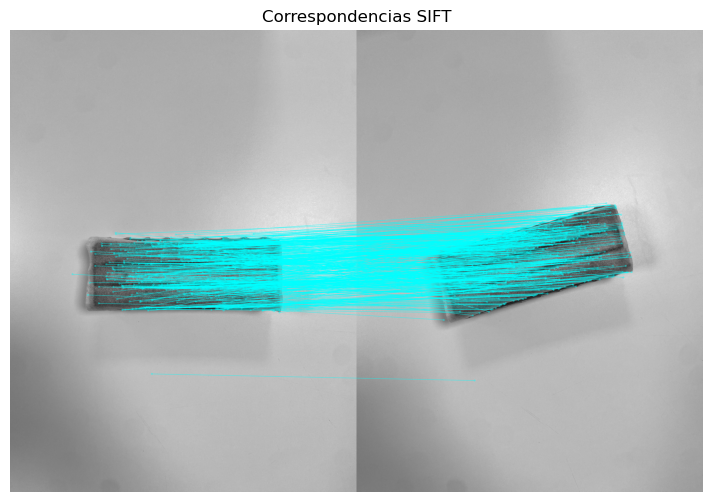

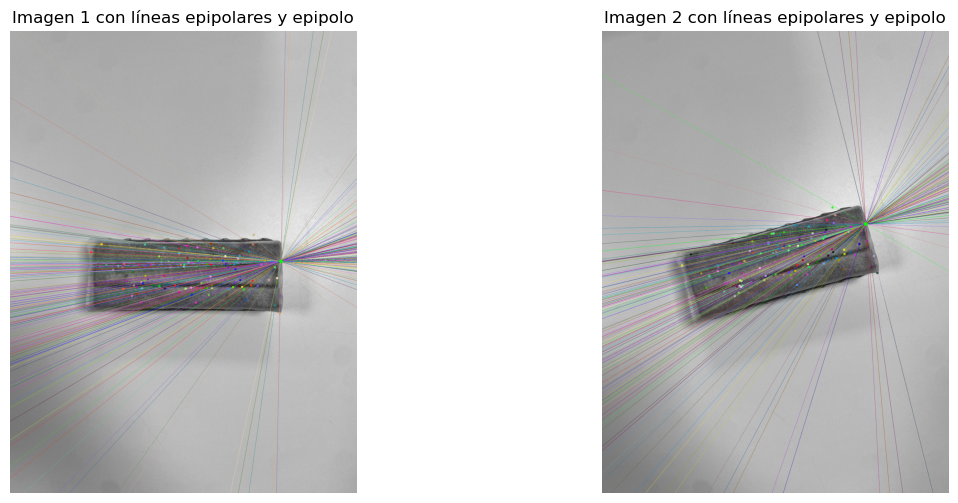

In [18]:

def process_and_show_matches_with_epilines(img1_path, img2_path, F, pts1, pts2):

    # Cargar imágenes en escala de grises
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)

    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                                  matchColor=(0, 255, 255), singlePointColor=(0, 0, 255), flags=2)

    plt.figure(figsize=(14, 6))
    plt.imshow(img_matches)
    plt.title("Correspondencias SIFT")
    plt.axis('off')
    plt.show()

    # Calcular líneas epipolares para puntos dados
    lines1 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F).reshape(-1, 3)
    lines2 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)

    def draw_lines(img, lines, pts):
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        h, w = img.shape
        for r, pt in zip(lines, pts):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = 0, int(-r[2] / r[1])
            x1, y1 = w, int(-(r[2] + r[0] * w) / r[1])
            cv2.line(img_color, (x0, y0), (x1, y1), color, 1)
            cv2.circle(img_color, tuple(pt.astype(int)), 5, color, -1)
        return img_color

    img1_lines = draw_lines(img1, lines2, pts1)
    img2_lines = draw_lines(img2, lines1, pts2)

    # Dibujar epipolos
    epipole1 = np.linalg.svd(F)[2][-1]
    epipole2 = np.linalg.svd(F.T)[2][-1]
    epipole1 = (epipole1 / epipole1[2])[:2].astype(int)
    epipole2 = (epipole2 / epipole2[2])[:2].astype(int)

    cv2.circle(img1_lines, tuple(epipole1), 8, (0, 255, 0), -1)
    cv2.circle(img2_lines, tuple(epipole2), 8, (0, 255, 0), -1)

    # Mostrar imágenes con líneas epipolares y epipolos
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1_lines, cv2.COLOR_BGR2RGB))
    plt.title("Imagen 1 con líneas epipolares y epipolo")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2_lines, cv2.COLOR_BGR2RGB))
    plt.title("Imagen 2 con líneas epipolares y epipolo")
    plt.axis('off')
    plt.show()
process_and_show_matches_with_epilines('izquierda.jpeg', 'derecha.jpeg', F, x1, x2)

In [19]:
K = np.array([
    [1491.86453,    0.0,       775.788473],
    [0.0,       1496.15689,   1016.88705],
    [0.0,          0.0,           1.0]
])
def normalizar_par_puntos(p1, p2, K):
  
    K_inv = np.linalg.inv(K)

    p1_h = np.array([p1[0], p1[1], 1.0])
    p2_h = np.array([p2[0], p2[1], 1.0])

    y1 = K_inv @ p1_h
    y2 = K_inv @ p2_h

    y1 /= y1[2]
    y2 /= y2[2]

    return y1, y2

img1 = cv2.imread('izquierda.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('derecha.jpeg', cv2.IMREAD_GRAYSCALE)

puntos1, puntos2, _ = detectar_coincidencias_SIFT(img1, img2)
i = 0  # índice del punto que quieres normalizar

y1, y2 = normalizar_par_puntos(puntos1[i], puntos2[i], K)

print("Punto normalizado en imagen 1:", y1)
print("Punto normalizado en imagen 2:", y2) 

Buenas coicidencias 133
Punto normalizado en imagen 1: [-0.28936089  0.10501175  1.        ]
Punto normalizado en imagen 2: [-0.25451753  0.14148589  1.        ]


In [20]:
def compute_relative_pose(E, y1, y2):
    # 1. Compute SVD of E=U S V^T (garantiza U,V ∈ SO(3))
    U, S, Vt = np.linalg.svd(E)
    if np.linalg.det(U) < 0:
        U *= -1
    if np.linalg.det(Vt) < 0:
        Vt *= -1

    # 2. Definir matriz W según ecuación (10.64)
    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])

    # 3. Calcular las 4 poses principales según ecuación (10.68)
    posibles_poses = [
        (U @ W @ Vt,  U[:, 2]),
        (U @ W @ Vt, -U[:, 2]),
        (U @ W.T @ Vt,  U[:, 2]),
        (U @ W.T @ Vt, -U[:, 2])
    ]

    # Matriz identidad 3x4 para cámara 1 (referencia)
    I = np.eye(3)
    zero = np.zeros((3,1))

    # 4. Para cada una de las 4 poses
    for R, t in posibles_poses:
        # Matrices de proyección cámara 1 y cámara 2
        P1 = np.hstack((I, zero))
        P2 = np.hstack((R, t.reshape(3,1)))

        # 4. Triangular punto 3D x correspondiente a y1,y2
        A = np.zeros((4,4))
        A[0] = y1[0]*P1[2] - P1[0]
        A[1] = y1[1]*P1[2] - P1[1]
        A[2] = y2[0]*P2[2] - P2[0]
        A[3] = y2[1]*P2[2] - P2[1]

        _, _, Vt_a = np.linalg.svd(A)
        X = Vt_a[-1]
        X /= X[3]

        # 5. Coordenadas relativas a cámara 1
        x_cam1 = X[:3]

        # 6. Coordenadas en cámara 2
        x_cam2 = R @ x_cam1 + t

        # 7. Devolver pose si x3 > 0 en ambas cámaras
        if x_cam1[2] > 0 and x_cam2[2] > 0:
            return R, t

    
    raise RuntimeError("No se encontró pose válida donde el punto esté delante de ambas cámaras.")

R, t = compute_relative_pose(E, y1, y2)

print("Matriz de rotación R:\n", R)
print("Vector de traslación t:\n", t)

Matriz de rotación R:
 [[ 0.96242263  0.27130674 -0.01163302]
 [-0.27154771  0.96184492 -0.03340947]
 [ 0.00212494  0.03531295  0.99937404]]
Vector de traslación t:
 [ 0.25254001 -0.10364395  0.96201948]


In [60]:
def calcular_homografias_rectificacion(K, R, t):
    """
    Calcula homografías Hl y Hr para rectificación estéreo calibrada,
    evitando problemas cuando t está cerca de [0,0,1].
    """
    t = t / np.linalg.norm(t)

    # Elegir vector arbitrario diferente de t para construir la base
    z_axis = np.array([0, 0, 1])
    if np.abs(np.dot(t, z_axis)) > 0.999:  # si t casi paralelo a z
        z_axis = np.array([0, 1, 0])       # cambiar vector de referencia

    r1 = t
    r2 = np.cross(z_axis, r1)
    r2 /= np.linalg.norm(r2)
    r3 = np.cross(r1, r2)

    R_rect = np.vstack((r1, r2, r3)).T

    Hl = K @ R_rect @ np.linalg.inv(K)
    Hr = K @ R_rect @ R.T @ np.linalg.inv(K)

    return Hl, Hr

In [78]:
Hl, Hr = calcular_homografias_rectificacion(K, R, t)

print("Homografía izquierda Hl:\n", Hl)
print("Homografía derecha Hr:\n", Hr)

Homografía izquierda Hl:
 [[ 7.52802337e-01  3.78585593e-01 -2.08495354e+03]
 [ 5.51791079e-01  9.25119996e-01 -5.44746859e+02]
 [ 6.44843723e-04  0.00000000e+00 -2.27281513e-01]]
Homografía derecha Hr:
 [[ 8.36224198e-01  1.85224936e-01 -1.92995821e+03]
 [ 7.76343868e-01  7.22012622e-01 -4.62304130e+02]
 [ 6.18483586e-04 -1.80699185e-04 -2.12076035e-02]]


In [110]:

def show_rectified_images_with_epilines(img1_path, img2_path, Hl, Hr, pts1, pts2):
   
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Validar carga
    if img1 is None or img2 is None:
        raise ValueError("Error al cargar las imágenes.")

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Normalizar homografías
    Hl = Hl / Hl[2, 2]
    Hr = Hr / Hr[2, 2]

    # Rectificar imágenes
    img1_rect = cv2.warpPerspective(img1, Hl, (w1, h1))
    img2_rect = cv2.warpPerspective(img2, Hr, (w2, h2))

    # Función para dibujar líneas horizontales y puntos
    def draw_horizontal_lines(img, pts):
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for pt in pts:
            y = int(round(pt[1]))
            color = tuple(np.random.randint(0, 255, 3).tolist())
            cv2.line(img_color, (0, y), (img.shape[1], y), color, 1)
            cv2.circle(img_color, (int(round(pt[0])), y), 5, color, -1)
        return img_color

    # Transformar puntos con homografías
    def transform_points(pts, H):
        pts_h = np.hstack([pts, np.ones((pts.shape[0],1))]).T
        pts_rect_h = H @ pts_h
        pts_rect = (pts_rect_h[:2] / pts_rect_h[2]).T
        return pts_rect

    pts1_rect = transform_points(pts1, Hl)
    pts2_rect = transform_points(pts2, Hr)

    img1_lines = draw_horizontal_lines(img1_rect, pts1_rect)
    img2_lines = draw_horizontal_lines(img2_rect, pts2_rect)

    # Mostrar imágenes rectificadas
    plt.figure(figsize=(14, 6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img1_lines, cv2.COLOR_BGR2RGB))
    plt.title("Imagen izquierda rectificada con líneas epipolares")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img2_lines, cv2.COLOR_BGR2RGB))
    plt.title("Imagen derecha rectificada con líneas epipolares")
    plt.axis('off')

    plt.show()

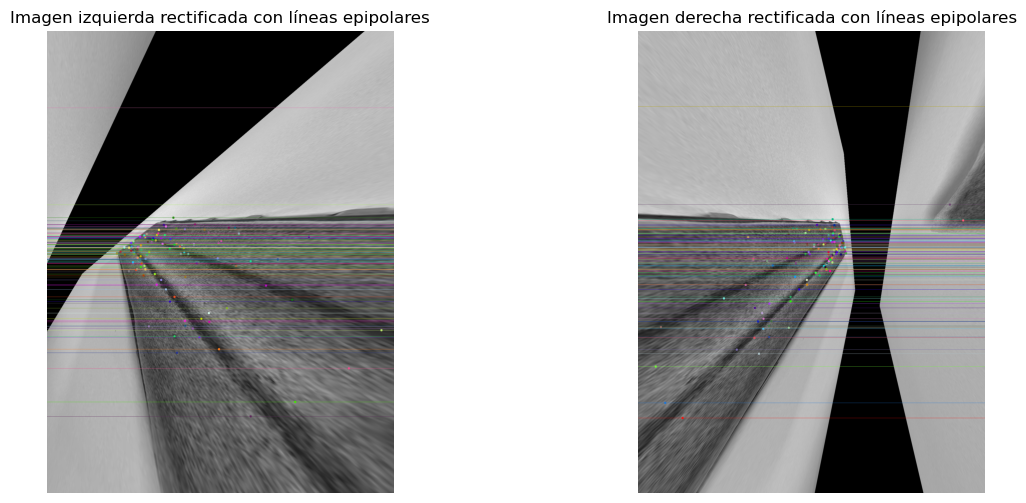

In [112]:
show_rectified_images_with_epilines('izquierda.jpeg', 'derecha.jpeg', Hl, Hr, puntos1, puntos2)